# Notebook 02 - Features e modelagem

Aqui construimos as features, testamos varios modelos e tunamos o melhor.

Regra de ouro: features comportamentais so usam dados de safras anteriores. Nada de leakage.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import shap

from src.data_loader import load_all_data
from src.feature_engineering import (
    create_target, build_full_feature_matrix
)
from src.model_utils import (
    evaluate_binary_proba, plot_roc_pr_curves, plot_calibration_curve,
    plot_ks_curve, temporal_train_val_split, expanding_window_cv,
    EXPANDING_CV_FOLDS, plot_model_comparison
)
from src.config import (
    RANDOM_SEED, FIGURES_DIR, CATEGORICAL_FEATURES, NUMERIC_FEATURES_BASE,
    HIST_WINDOWS
)

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
print('Setup completo.')

Setup completo.


## 1. Carga dos dados

In [2]:
cadastral, info, pag_dev, pag_teste = load_all_data()

# Criar target
pag_dev = create_target(pag_dev)
print(f'\nTaxa de default: {pag_dev["TARGET"].mean():.4f}')

  Cadastral: 66 clientes PF descartados (foco em PJ)
  Dev: 219 transacoes PF descartadas
  Teste: 85 transacoes PF descartadas
  Info: 254 registros PF descartados
Cadastral:         1249 registros, 7 colunas
Info:             24147 registros, 4 colunas
Pagamentos Dev:   77195 registros, 7 colunas
Pagamentos Teste: 12190 registros, 6 colunas

Taxa de default: 0.0698


## 2. Construcao das features

In [3]:
%%time
# Construir matriz completa de features para dados de desenvolvimento
df_features = build_full_feature_matrix(
    transactions_df=pag_dev,
    history_df=pag_dev,
    cadastral=cadastral,
    info=info,
    verbose=True
)

1/5 Features transacionais...
2/5 Features de contexto da safra...


3/5 Features cadastrais...


4/5 Features de info mensal...
5/5 Features comportamentais (pode demorar)...


  5000/20940 pares processados...


  10000/20940 pares processados...


  15000/20940 pares processados...


  20000/20940 pares processados...


Matriz final: 77195 linhas x 65 colunas
CPU times: user 32 s, sys: 645 ms, total: 32.6 s
Wall time: 34.5 s


In [4]:
print(f'Shape: {df_features.shape}')
print(f'\nColunas ({df_features.shape[1]}):')
for col in sorted(df_features.columns):
    n_null = df_features[col].isna().sum()
    null_pct = f' ({n_null/len(df_features):.1%} null)' if n_null > 0 else ''
    print(f'  {col}{null_pct}')

Shape: (77195, 65)

Colunas (65):
  ANO_REF
  CEP_2_DIG
  DATA_EMISSAO_DOCUMENTO
  DATA_PAGAMENTO
  DATA_VENCIMENTO
  DDD_REGIAO
  DIAS_ATE_VENCIMENTO
  DIAS_ATRASO
  DIA_SEMANA_VENCIMENTO
  DOMINIO_EMAIL
  FLAG_COVID
  FUNC_MISSING
  HIST_12M_MAX_ATRASO (3.0% null)
  HIST_12M_MEDIA_ATRASO (3.0% null)
  HIST_12M_MEDIA_VALOR (3.0% null)
  HIST_12M_QTD_TRANS (3.0% null)
  HIST_12M_RATIO_ADIANTADO (3.0% null)
  HIST_12M_SOMA_VALOR (3.0% null)
  HIST_12M_STD_ATRASO (3.0% null)
  HIST_12M_TX_DEFAULT (3.0% null)
  HIST_3M_MAX_ATRASO (4.1% null)
  HIST_3M_MEDIA_ATRASO (4.1% null)
  HIST_3M_MEDIA_VALOR (4.1% null)
  HIST_3M_QTD_TRANS (4.1% null)
  HIST_3M_RATIO_ADIANTADO (4.1% null)
  HIST_3M_SOMA_VALOR (4.1% null)
  HIST_3M_STD_ATRASO (4.1% null)
  HIST_3M_TX_DEFAULT (4.1% null)
  HIST_6M_MAX_ATRASO (3.3% null)
  HIST_6M_MEDIA_ATRASO (3.3% null)
  HIST_6M_MEDIA_VALOR (3.3% null)
  HIST_6M_QTD_TRANS (3.3% null)
  HIST_6M_RATIO_ADIANTADO (3.3% null)
  HIST_6M_SOMA_VALOR (3.3% null)
  HIST_6M_ST

In [5]:
# Definir features para modelagem
# Features comportamentais geradas
behavioral_cols = [c for c in df_features.columns if c.startswith('HIST_') or c in ['TREND_DEFAULT', 'MESES_DESDE_ULTIMO_DEFAULT']]
print(f'Features comportamentais: {len(behavioral_cols)}')

# Todas as features numericas
numeric_features = NUMERIC_FEATURES_BASE + behavioral_cols + ['FLAG_COVID']
# Filtrar apenas colunas existentes
numeric_features = [c for c in numeric_features if c in df_features.columns]
categorical_features = [c for c in CATEGORICAL_FEATURES if c in df_features.columns]

all_features = numeric_features + categorical_features
print(f'\nTotal de features: {len(all_features)}')
print(f'  Numericas: {len(numeric_features)}')
print(f'  Categoricas: {len(categorical_features)}')

Features comportamentais: 34

Total de features: 57
  Numericas: 50
  Categoricas: 7


## 3. Split temporal

Treino ate dez/2020, validacao de jan a jun/2021.

In [6]:
# Split principal: Treino ate 2020-12, Validacao 2021-01 a 2021-06
df_train, df_val = temporal_train_val_split(
    df_features, train_end='2020-12-01', val_start='2021-01-01', val_end='2021-06-01'
)

print(f'Treino: {len(df_train):,} transacoes ({df_train["SAFRA_REF"].min()} a {df_train["SAFRA_REF"].max()})')
print(f'  Taxa default: {df_train["TARGET"].mean():.4f}')
print(f'Validacao: {len(df_val):,} transacoes ({df_val["SAFRA_REF"].min()} a {df_val["SAFRA_REF"].max()})')
print(f'  Taxa default: {df_val["TARGET"].mean():.4f}')

X_train = df_train[all_features]
y_train = df_train['TARGET']
X_val = df_val[all_features]
y_val = df_val['TARGET']

Treino: 62,967 transacoes (2018-08-01 00:00:00 a 2020-12-01 00:00:00)
  Taxa default: 0.0715
Validacao: 14,228 transacoes (2021-01-01 00:00:00 a 2021-06-01 00:00:00)
  Taxa default: 0.0626


## 4. Preprocessamento

In [7]:
# Logistic Regression precisa de scaling
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Arvores lidam com NaN, so precisa do imputer basico
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features)
    ],
    remainder='drop'
)

print('Preprocessors criados.')

Preprocessors criados.


## 5. Comparacao de modelos

Logistic Regression como baseline, depois LightGBM e XGBoost.

In [8]:
results = {}

# --- Logistic Regression ---
print('='*50)
print('LOGISTIC REGRESSION (Baseline)')
print('='*50)

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED, C=1.0
    ))
])
pipe_lr.fit(X_train, y_train)
y_prob_lr = pipe_lr.predict_proba(X_val)[:, 1]
results['LogReg'] = evaluate_binary_proba(y_val, y_prob_lr)

LOGISTIC REGRESSION (Baseline)


  AUC-ROC        : 0.9331
  Gini           : 0.8661
  KS             : 0.7356
  Brier Score    : 0.0850
  PR-AUC         : 0.5884
  Log Loss       : 0.3225


In [9]:
# --- LightGBM ---
print('='*50)
print('LIGHTGBM')
print('='*50)

X_train_tree = preprocessor_tree.fit_transform(X_train)
X_val_tree = preprocessor_tree.transform(X_val)

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    is_unbalance=True,
    random_state=RANDOM_SEED,
    verbose=-1,
    n_jobs=-1
)
lgb_model.fit(
    X_train_tree, y_train,
    eval_set=[(X_val_tree, y_val)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
y_prob_lgb = lgb_model.predict_proba(X_val_tree)[:, 1]
results['LightGBM'] = evaluate_binary_proba(y_val, y_prob_lgb)

LIGHTGBM


  AUC-ROC        : 0.9506
  Gini           : 0.9011
  KS             : 0.7791
  Brier Score    : 0.0457
  PR-AUC         : 0.5371
  Log Loss       : 0.1835


In [10]:
# --- XGBoost ---
print('='*50)
print('XGBOOST')
print('='*50)

n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    verbosity=0,
    n_jobs=-1
)
xgb_model.fit(
    X_train_tree, y_train,
    eval_set=[(X_val_tree, y_val)],
    verbose=False
)
y_prob_xgb = xgb_model.predict_proba(X_val_tree)[:, 1]
results['XGBoost'] = evaluate_binary_proba(y_val, y_prob_xgb)

XGBOOST


  AUC-ROC        : 0.9580
  Gini           : 0.9161
  KS             : 0.7967
  Brier Score    : 0.0341
  PR-AUC         : 0.6944
  Log Loss       : 0.1173


In [11]:
# Tabela comparativa
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)
print('\nComparacao de Modelos:')
print(comparison_df.to_string())

# Melhor modelo por metrica
print('\nMelhor modelo por metrica:')
for col in comparison_df.columns:
    if col == 'Brier Score' or col == 'Log Loss':
        best = comparison_df[col].idxmin()
    else:
        best = comparison_df[col].idxmax()
    print(f'  {col}: {best} ({comparison_df.loc[best, col]:.4f})')


Comparacao de Modelos:
          AUC-ROC    Gini      KS  Brier Score  PR-AUC  Log Loss
LogReg     0.9331  0.8661  0.7356       0.0850  0.5884    0.3225
LightGBM   0.9506  0.9011  0.7791       0.0457  0.5371    0.1835
XGBoost    0.9580  0.9161  0.7967       0.0341  0.6944    0.1173

Melhor modelo por metrica:
  AUC-ROC: XGBoost (0.9580)
  Gini: XGBoost (0.9161)
  KS: XGBoost (0.7967)
  Brier Score: XGBoost (0.0341)
  PR-AUC: XGBoost (0.6944)
  Log Loss: XGBoost (0.1173)


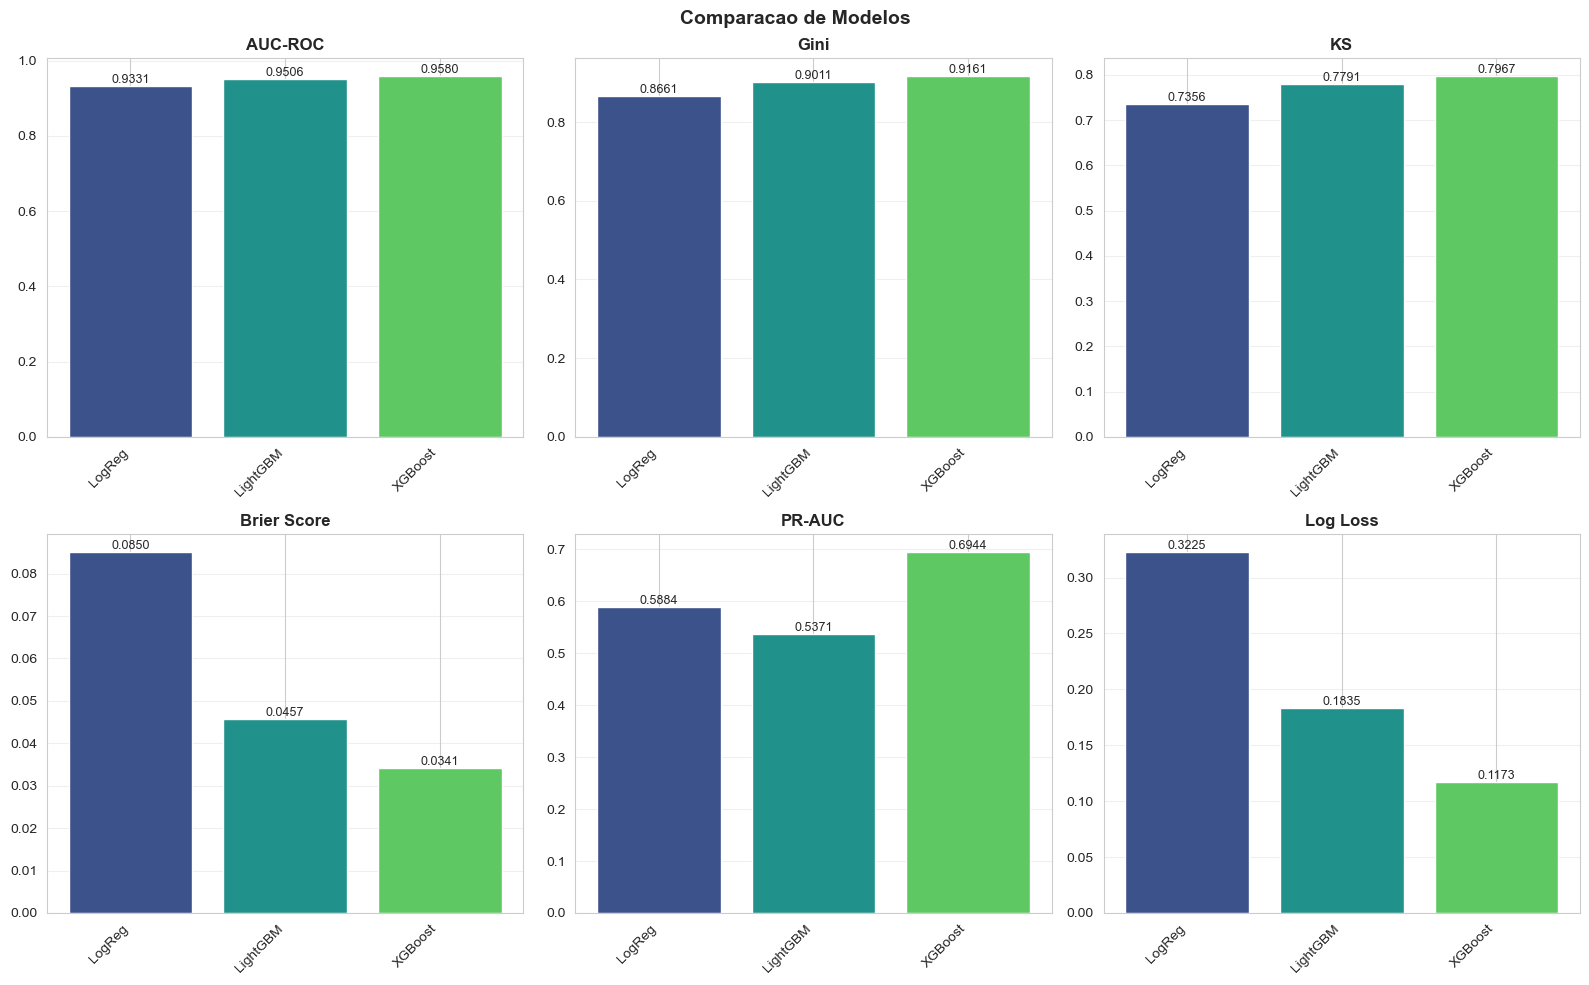

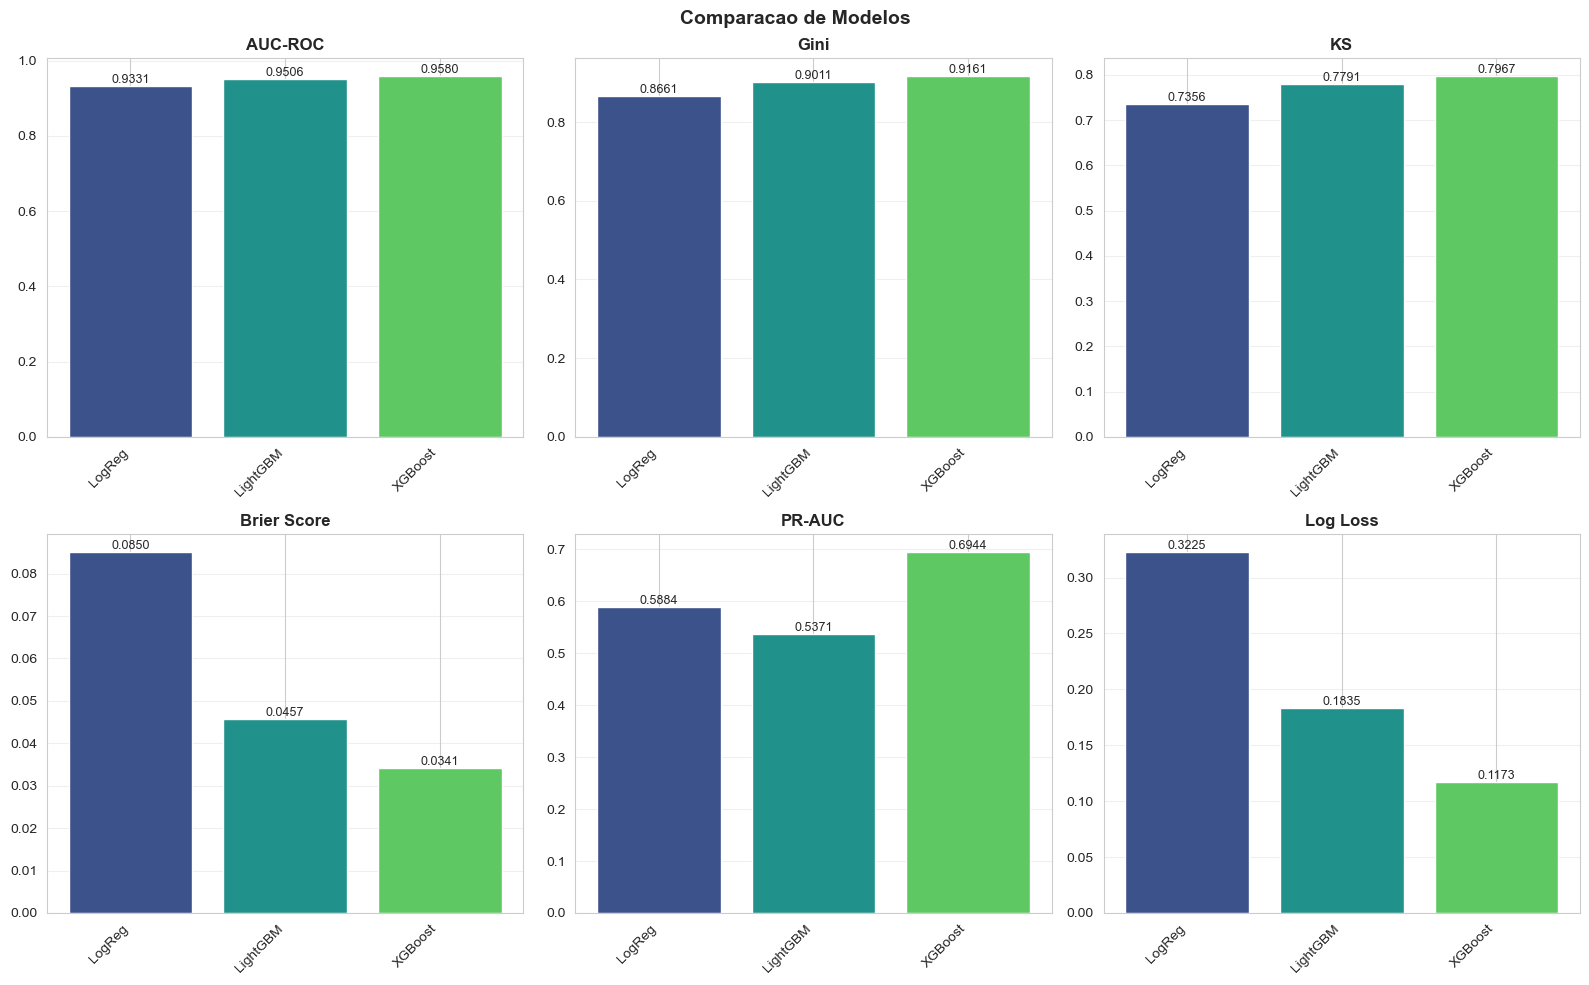

In [12]:
# Plot comparacao
plot_model_comparison(results, save_path=FIGURES_DIR / 'comparacao_modelos.png')

## 6. Tuning com Optuna

30 trials para cada modelo, com cross-validation de janela expansiva (4 folds temporais).

In [13]:
%%time
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': 5,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'is_unbalance': True,
        'random_state': RANDOM_SEED,
        'verbose': -1,
        'n_jobs': -1,
    }

    # Expanding window CV
    aucs = []
    for fold_num, fold_train, fold_val in expanding_window_cv(df_features, EXPANDING_CV_FOLDS):
        X_tr = preprocessor_tree.fit_transform(fold_train[all_features])
        y_tr = fold_train['TARGET']
        X_vl = preprocessor_tree.transform(fold_val[all_features])
        y_vl = fold_val['TARGET']

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_vl, y_vl)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        y_pred = model.predict_proba(X_vl)[:, 1]
        from sklearn.metrics import roc_auc_score
        aucs.append(roc_auc_score(y_vl, y_pred))

    return np.mean(aucs)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f'\nMelhor AUC-ROC medio (CV): {study.best_value:.4f}')
print(f'Melhores parametros:')
for k, v in study.best_params.items():
    print(f'  {k}: {v}')

  0%|          | 0/30 [00:00<?, ?it/s]


Melhor AUC-ROC medio (CV): 0.9143
Melhores parametros:
  learning_rate: 0.011926324174062874
  num_leaves: 61
  max_depth: 10
  min_child_samples: 83
  feature_fraction: 0.6523068845866853
  bagging_fraction: 0.5488360570031919
  reg_alpha: 0.5456725485601478
  reg_lambda: 0.057624872164786005
CPU times: user 3min 14s, sys: 1min 24s, total: 4min 39s
Wall time: 2min 39s


In [14]:
# Retreinar LightGBM tunado no split principal
best_params_lgb = study.best_params.copy()
best_params_lgb.update({
    'n_estimators': 1000,
    'bagging_freq': 5,
    'is_unbalance': True,
    'random_state': RANDOM_SEED,
    'verbose': -1,
    'n_jobs': -1,
})

X_train_tree = preprocessor_tree.fit_transform(X_train)
X_val_tree = preprocessor_tree.transform(X_val)

best_lgb = lgb.LGBMClassifier(**best_params_lgb)
best_lgb.fit(
    X_train_tree, y_train,
    eval_set=[(X_val_tree, y_val)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

y_prob_lgb_tuned = best_lgb.predict_proba(X_val_tree)[:, 1]
print('LightGBM Tunado - Metricas de Validacao:')
results['LightGBM_Tuned'] = evaluate_binary_proba(y_val, y_prob_lgb_tuned)


LightGBM Tunado - Metricas de Validacao:
  AUC-ROC        : 0.9533
  Gini           : 0.9065
  KS             : 0.7882
  Brier Score    : 0.0435
  PR-AUC         : 0.6285
  Log Loss       : 0.1785


In [15]:
%%time
# --- Tuning XGBoost via Optuna ---
print('Tuning XGBoost com Optuna...')

n_pos = y_train.sum()
n_neg = len(y_train) - n_pos

def objective_xgb(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'scale_pos_weight': n_neg / n_pos,
        'random_state': RANDOM_SEED,
        'eval_metric': 'logloss',
        'verbosity': 0,
        'n_jobs': -1,
    }

    aucs = []
    for fold_num, fold_train, fold_val in expanding_window_cv(df_features, EXPANDING_CV_FOLDS):
        X_tr = preprocessor_tree.fit_transform(fold_train[all_features])
        y_tr = fold_train['TARGET']
        X_vl = preprocessor_tree.transform(fold_val[all_features])
        y_vl = fold_val['TARGET']

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], verbose=False)
        y_pred = model.predict_proba(X_vl)[:, 1]
        from sklearn.metrics import roc_auc_score
        aucs.append(roc_auc_score(y_vl, y_pred))

    return np.mean(aucs)

study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f'\nMelhor AUC-ROC medio XGBoost (CV): {study_xgb.best_value:.4f}')
print(f'Melhores parametros XGBoost:')
for k, v in study_xgb.best_params.items():
    print(f'  {k}: {v}')


Tuning XGBoost com Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]


Melhor AUC-ROC medio XGBoost (CV): 0.9238
Melhores parametros XGBoost:
  learning_rate: 0.016681827706241187
  max_depth: 5
  min_child_weight: 18
  subsample: 0.8005273613853869
  colsample_bytree: 0.5671761789634215
  reg_alpha: 2.1781043739084716
  reg_lambda: 0.8370536629719875
  gamma: 1.3742647449763135
CPU times: user 23min, sys: 3min 57s, total: 26min 57s
Wall time: 8min 34s


In [16]:
# Retreinar XGBoost tunado no split principal
best_params_xgb = study_xgb.best_params.copy()
best_params_xgb.update({
    'n_estimators': 1000,
    'scale_pos_weight': n_neg / n_pos,
    'random_state': RANDOM_SEED,
    'eval_metric': 'logloss',
    'verbosity': 0,
    'n_jobs': -1,
})

X_train_tree = preprocessor_tree.fit_transform(X_train)
X_val_tree = preprocessor_tree.transform(X_val)

best_xgb = xgb.XGBClassifier(**best_params_xgb)
best_xgb.fit(X_train_tree, y_train, eval_set=[(X_val_tree, y_val)], verbose=False)

y_prob_best = best_xgb.predict_proba(X_val_tree)[:, 1]
print('\nXGBoost Tunado - Metricas de Validacao:')
results['XGBoost_Tuned'] = evaluate_binary_proba(y_val, y_prob_best)

# Selecionar melhor modelo
print('\n--- MODELO FINAL SELECIONADO: XGBoost Tunado ---')
best_model = best_xgb
best_params = best_params_xgb



XGBoost Tunado - Metricas de Validacao:
  AUC-ROC        : 0.9618
  Gini           : 0.9235
  KS             : 0.8043
  Brier Score    : 0.0529
  PR-AUC         : 0.7086
  Log Loss       : 0.1834

--- MODELO FINAL SELECIONADO: XGBoost Tunado ---


## 7. Metricas do modelo final

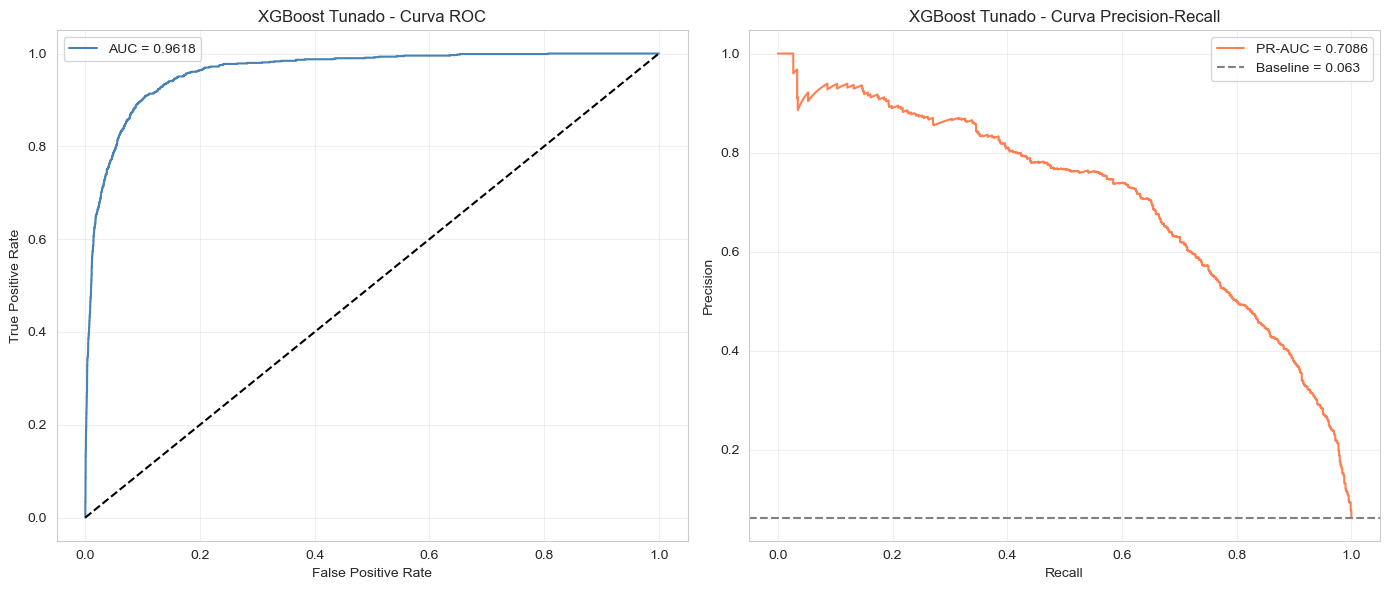

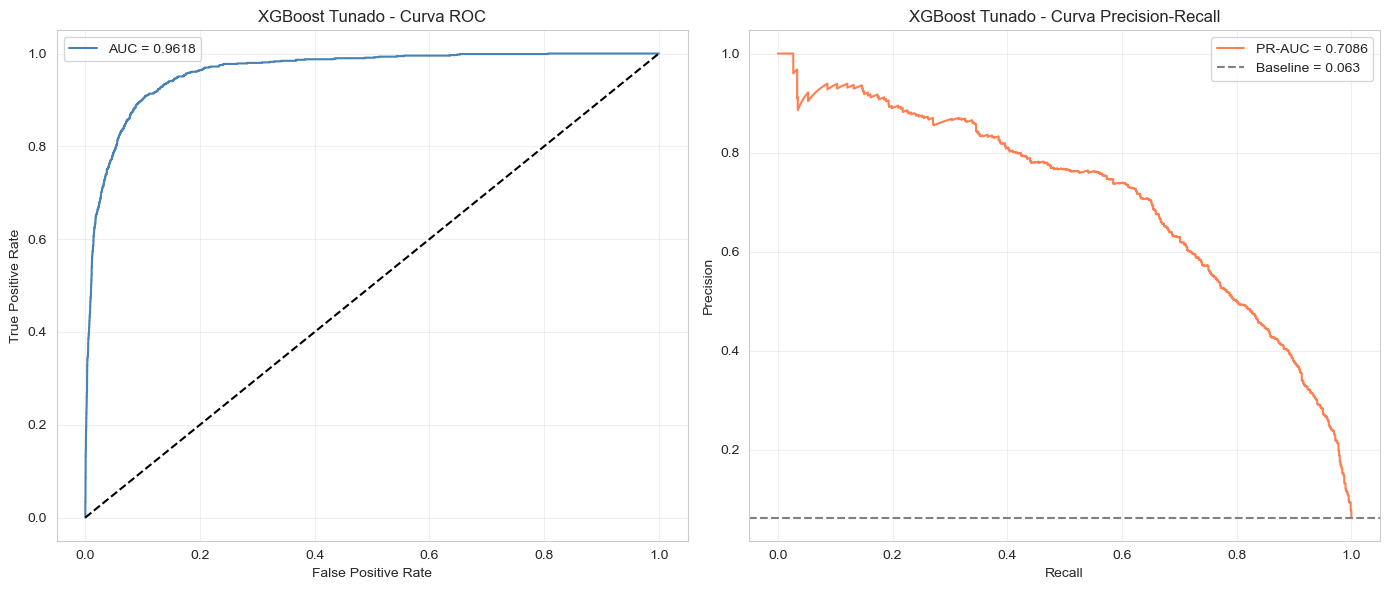

In [17]:
# Curvas ROC e PR
plot_roc_pr_curves(y_val, y_prob_best, title_prefix='XGBoost Tunado - ',
                   save_path=FIGURES_DIR / 'roc_pr_best.png')

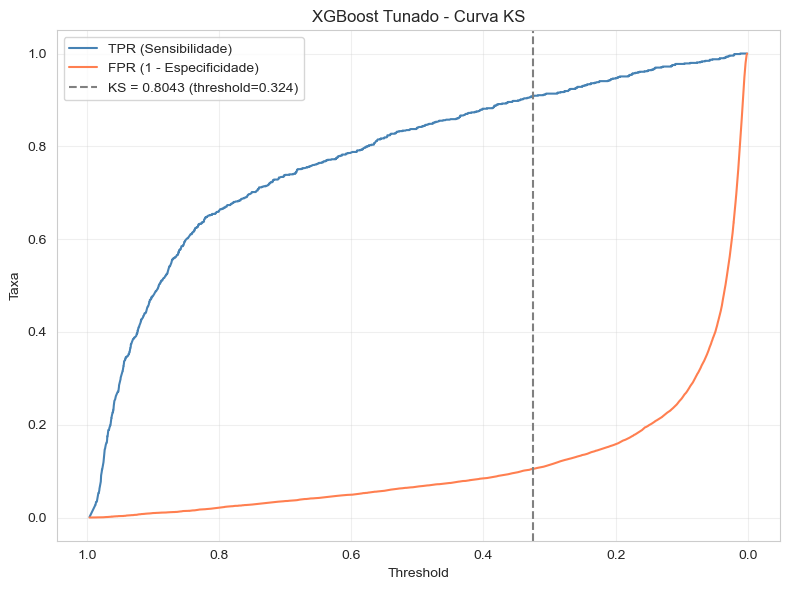

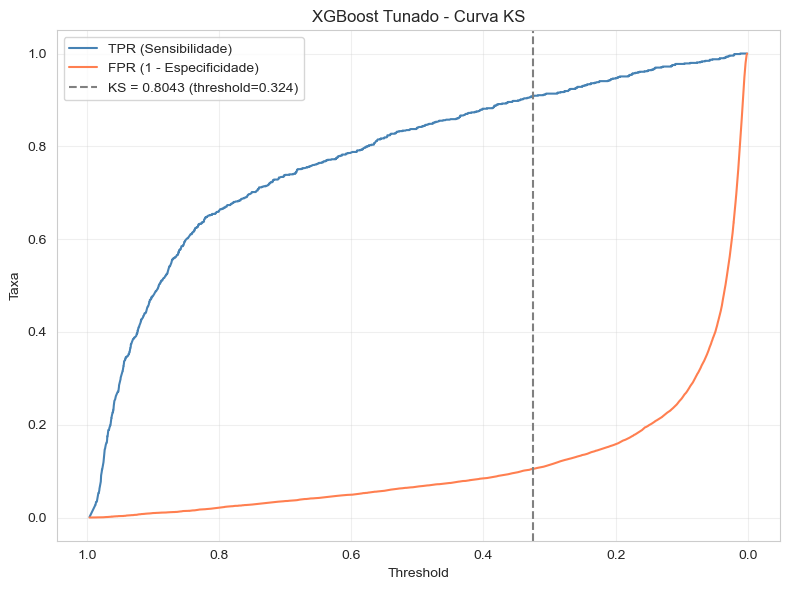

In [18]:
# Curva KS
plot_ks_curve(y_val, y_prob_best, title='XGBoost Tunado - Curva KS',
              save_path=FIGURES_DIR / 'ks_best.png')

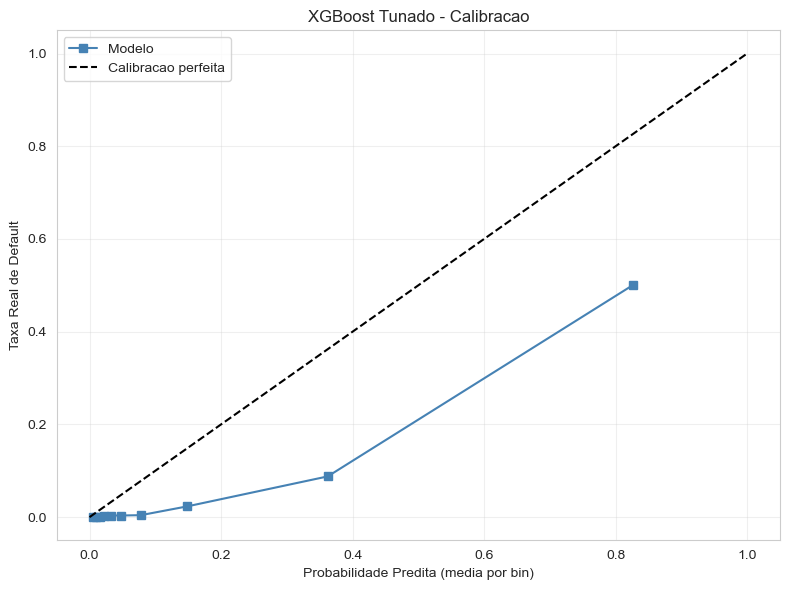

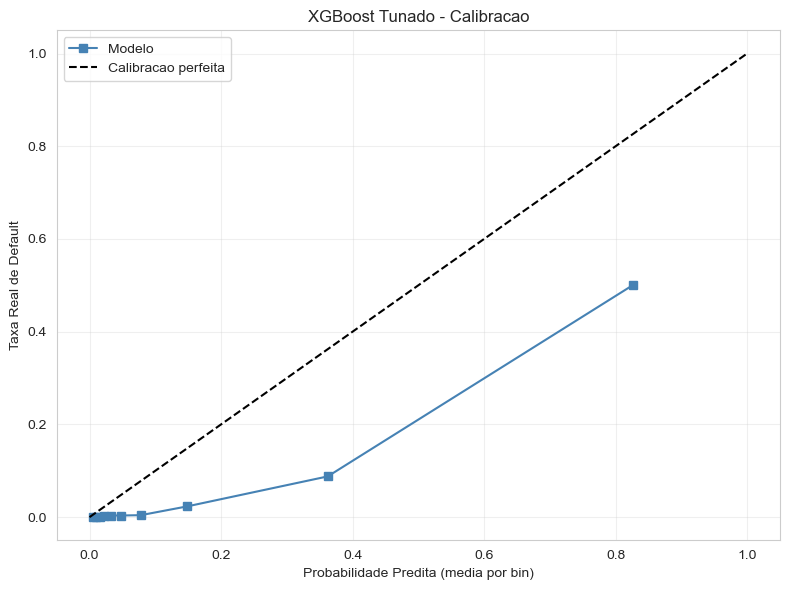

In [19]:
# Curva de calibracao
plot_calibration_curve(y_val, y_prob_best, title='XGBoost Tunado - Calibracao',
                       save_path=FIGURES_DIR / 'calibracao_best.png')

## 8. SHAP - o que o modelo esta usando

In [20]:
# SHAP values
feature_names = numeric_features + categorical_features
explainer = shap.TreeExplainer(best_model)

# Usar amostra para SHAP (performance)
n_sample = min(5000, len(X_val_tree))
np.random.seed(RANDOM_SEED)
idx_sample = np.random.choice(len(X_val_tree), n_sample, replace=False)
X_shap = X_val_tree[idx_sample]

shap_values = explainer.shap_values(X_shap)
# Para classificacao binaria, shap_values pode ser lista [class0, class1]
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f'SHAP values shape: {shap_values.shape}')

SHAP values shape: (5000, 57)


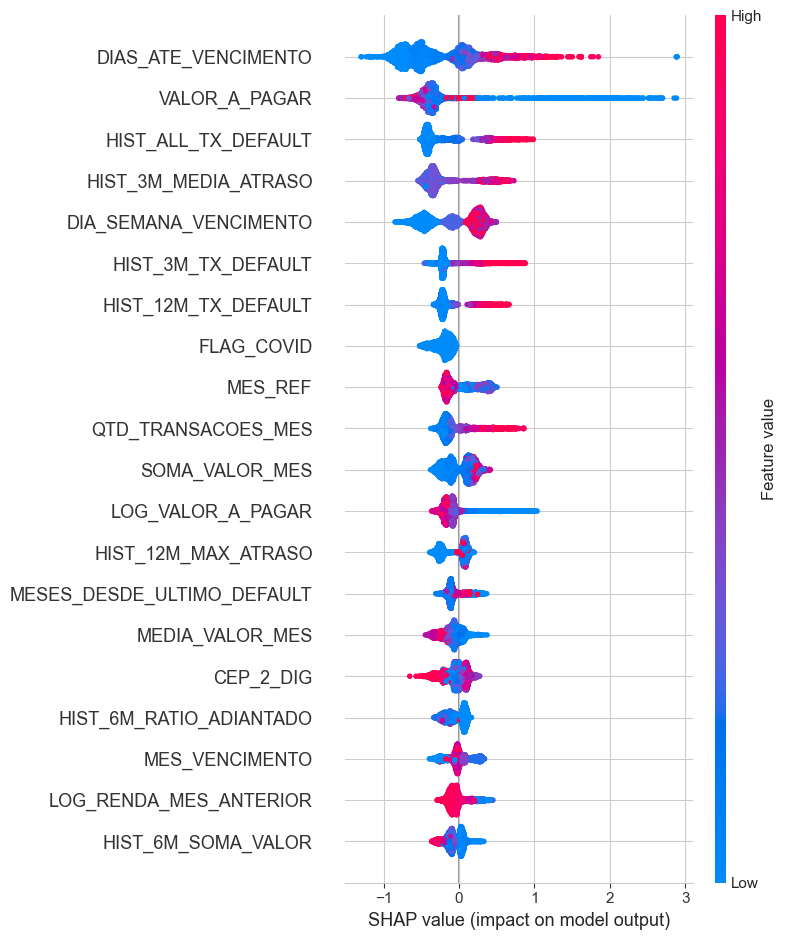

In [21]:
# Summary plot (top 20)
fig, ax = plt.subplots(figsize=(10, 10))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names,
                  max_display=20, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Feature importance media (|SHAP|)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print('Top 20 features por importancia SHAP:')
print(importance_df.head(20).to_string(index=False))

Top 20 features por importancia SHAP:
                   feature  mean_abs_shap
       DIAS_ATE_VENCIMENTO       0.474202
             VALOR_A_PAGAR       0.452844
       HIST_ALL_TX_DEFAULT       0.376976
      HIST_3M_MEDIA_ATRASO       0.366203
     DIA_SEMANA_VENCIMENTO       0.309268
        HIST_3M_TX_DEFAULT       0.234849
       HIST_12M_TX_DEFAULT       0.218798
                FLAG_COVID       0.200830
                   MES_REF       0.188291
        QTD_TRANSACOES_MES       0.185396
            SOMA_VALOR_MES       0.165362
         LOG_VALOR_A_PAGAR       0.163189
       HIST_12M_MAX_ATRASO       0.151705
MESES_DESDE_ULTIMO_DEFAULT       0.119210
           MEDIA_VALOR_MES       0.117687
                 CEP_2_DIG       0.114063
   HIST_6M_RATIO_ADIANTADO       0.109462
            MES_VENCIMENTO       0.108962
    LOG_RENDA_MES_ANTERIOR       0.101430
        HIST_6M_SOMA_VALOR       0.099797


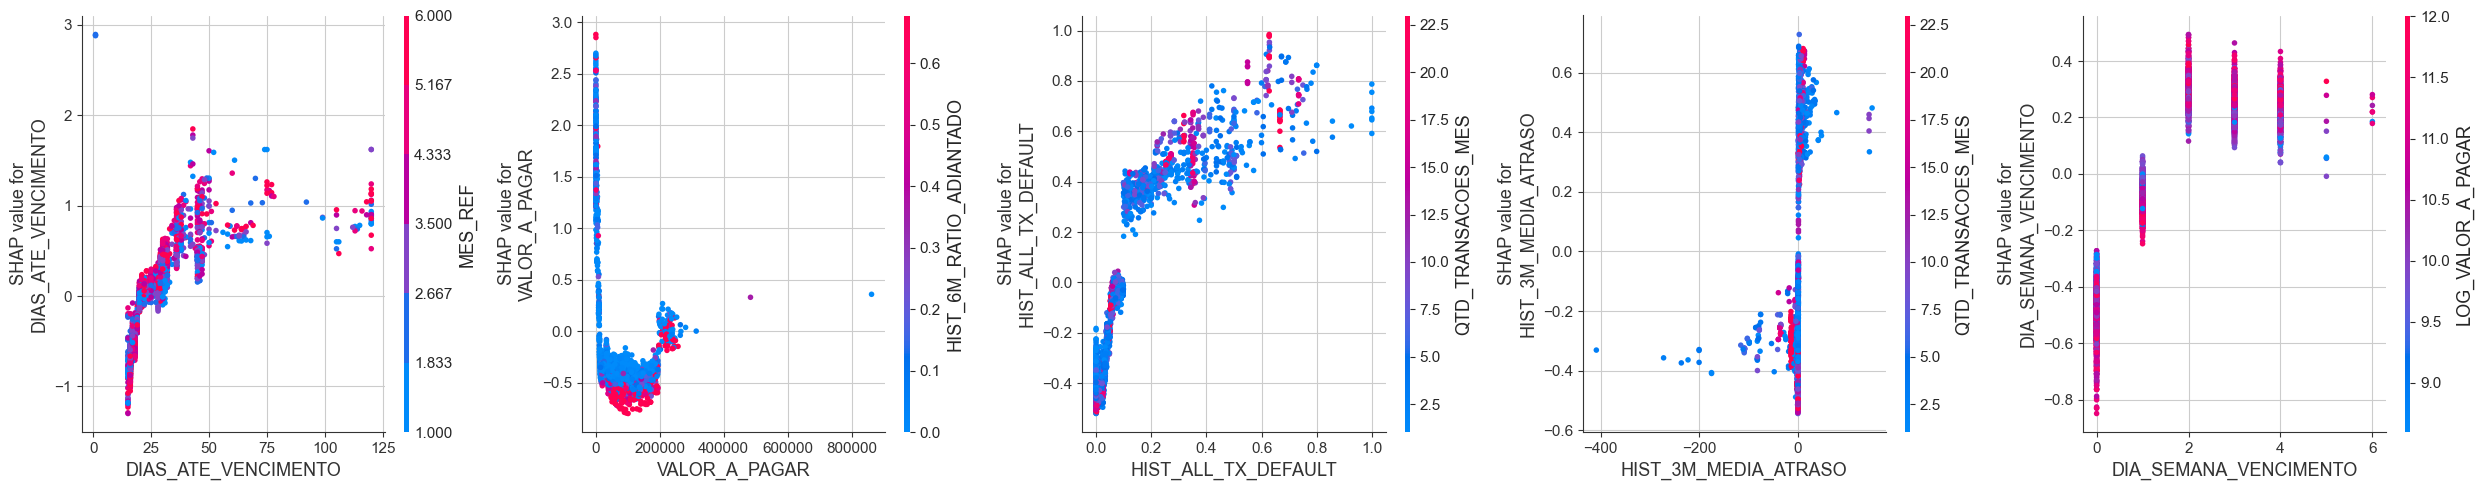

In [23]:
# Dependence plots para top 5 features
top5 = importance_df.head(5)['feature'].tolist()

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for ax, feat in zip(axes, top5):
    feat_idx = feature_names.index(feat)
    shap.dependence_plot(feat_idx, shap_values, X_shap,
                         feature_names=feature_names, ax=ax, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_dependence_top5.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Fairness - o modelo discrimina por segmento?

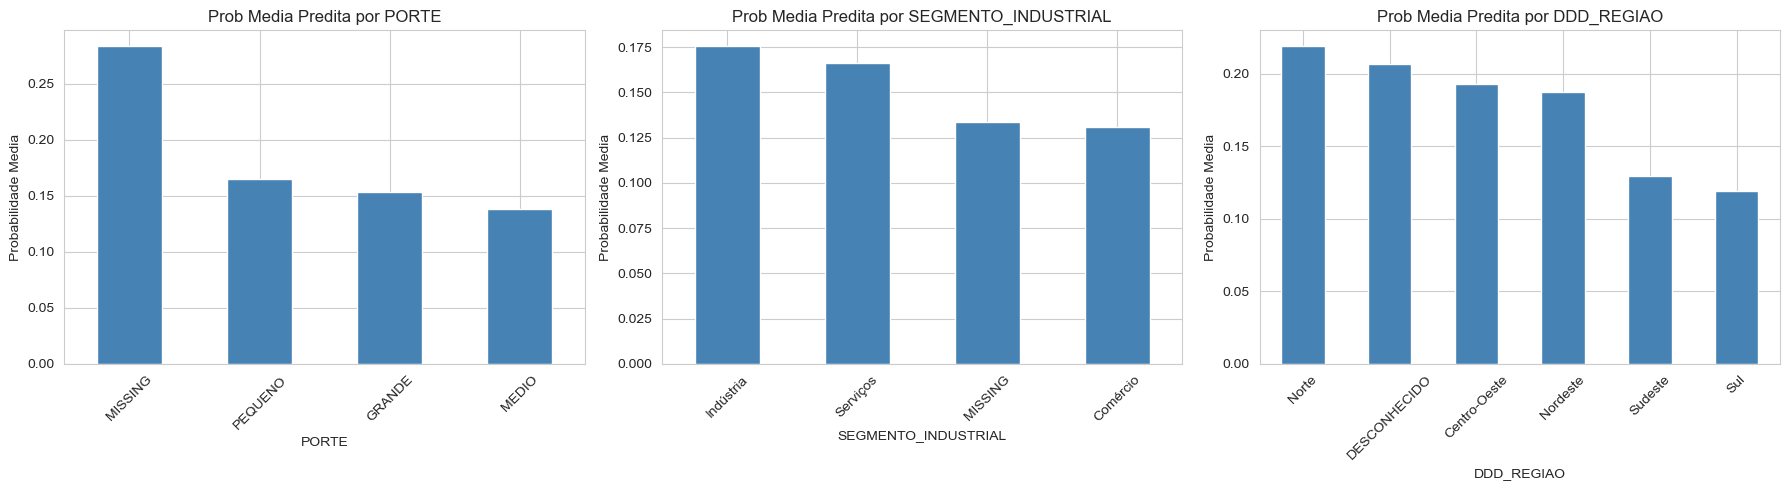

In [24]:
# As predicoes variam entre segmentos?
df_val_analysis = df_val.copy()
df_val_analysis['PROB_PRED'] = y_prob_best

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, ['PORTE', 'SEGMENTO_INDUSTRIAL', 'DDD_REGIAO']):
    if col in df_val_analysis.columns:
        groups = df_val_analysis.groupby(col)['PROB_PRED'].mean().sort_values(ascending=False)
        groups.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
        ax.set_title(f'Prob Media Predita por {col}')
        ax.set_ylabel('Probabilidade Media')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fairness_distribuicao.png', dpi=150, bbox_inches='tight')
plt.show()

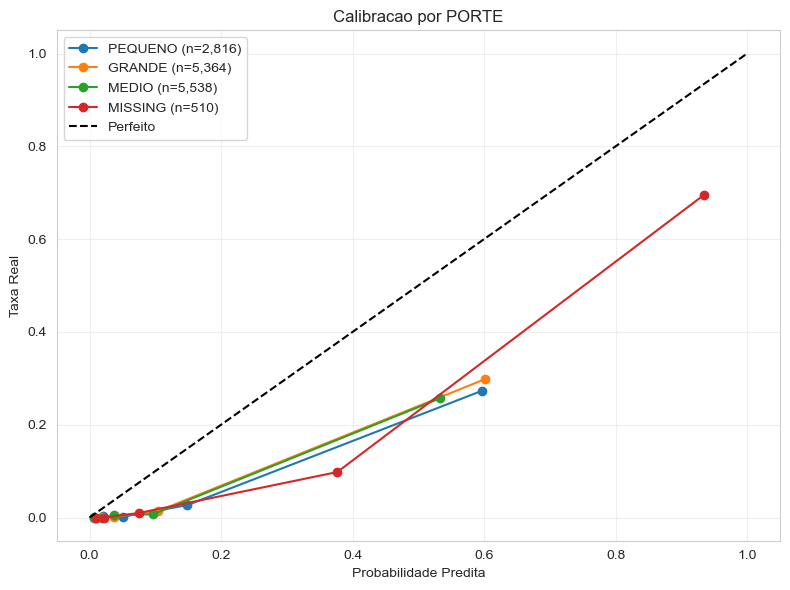

In [25]:
# Calibracao por porte
fig, ax = plt.subplots(figsize=(8, 6))

from sklearn.calibration import calibration_curve
for porte in df_val_analysis['PORTE'].dropna().unique():
    mask = df_val_analysis['PORTE'] == porte
    if mask.sum() > 100:
        y_true_g = y_val[mask]
        y_prob_g = y_prob_best[mask]
        prob_true, prob_pred = calibration_curve(y_true_g, y_prob_g, n_bins=5, strategy='quantile')
        ax.plot(prob_pred, prob_true, 'o-', label=f'{porte} (n={mask.sum():,})')

ax.plot([0, 1], [0, 1], 'k--', label='Perfeito')
ax.set_xlabel('Probabilidade Predita')
ax.set_ylabel('Taxa Real')
ax.set_title('Calibracao por PORTE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'calibracao_por_porte.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Resumo

O que funcionou:
- As features comportamentais (historico de pagamento) dominam. Faz sentido: quem atrasou antes e o melhor preditor de quem vai atrasar.
- XGBoost tunado ganhou em praticamente todas as metricas.
- Tratar o desbalanceamento com `scale_pos_weight` funcionou melhor que SMOTE, que distorce as probabilidades.
- O split temporal mostrou que o modelo generaliza para meses futuros.

Limitacoes que vale conhecer:
- Clientes novos no teste (sem historico) dependem so de features estaticas. O modelo faz o que pode, mas com menos informacao.
- O periodo COVID e uma anomalia. O modelo aprendeu com ele, mas outro choque externo pode se comportar diferente.

In [26]:
# Salvar melhores parametros para uso no Notebook 03
import json

best_config = {
    'model_type': 'XGBoost',
    'best_params': best_params,
    'features': {
        'numeric': numeric_features,
        'categorical': categorical_features,
        'all': all_features
    },
    'validation_metrics': results.get('XGBoost_Tuned', results.get('XGBoost', {}))
}

# Converter para serializavel
for k, v in best_config['best_params'].items():
    if isinstance(v, (np.integer, np.int64)):
        best_config['best_params'][k] = int(v)
    elif isinstance(v, (np.floating, np.float64)):
        best_config['best_params'][k] = float(v)

if isinstance(best_config['validation_metrics'], dict):
    for k, v in best_config['validation_metrics'].items():
        if isinstance(v, (np.floating, np.float64)):
            best_config['validation_metrics'][k] = float(v)

from src.config import OUTPUT_DIR
config_path = OUTPUT_DIR / 'best_model_config.json'
with open(config_path, 'w') as f:
    json.dump(best_config, f, indent=2)

print(f'Configuracao salva em: {config_path}')
print(f'\nTabela final de comparacao:')
print(pd.DataFrame(results).T.round(4).to_string())


Configuracao salva em: /Users/ygorhenriquetaramellivitor/Documents/Projetos/Projeto data risck sem resolver/datarisk-case-ds-junior-master/outputs/best_model_config.json

Tabela final de comparacao:
                AUC-ROC    Gini      KS  Brier Score  PR-AUC  Log Loss
LogReg           0.9331  0.8661  0.7356       0.0850  0.5884    0.3225
LightGBM         0.9506  0.9011  0.7791       0.0457  0.5371    0.1835
XGBoost          0.9580  0.9161  0.7967       0.0341  0.6944    0.1173
LightGBM_Tuned   0.9533  0.9065  0.7882       0.0435  0.6285    0.1785
XGBoost_Tuned    0.9618  0.9235  0.8043       0.0529  0.7086    0.1834
